# Train Models
In this notebook, we will use the dataset created in `load-analyze-dataset.ipynb` to train two different models.
- Baseline CNN 
- Inception like model

In [1]:
import pandas as pd
import numpy as np

import data_cstm
import utils_cstm
import train_cstm

from matplotlib import pyplot as plt

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torchvision

import pickle


# base directory of where the projects files and data will be stored
# you may need to change this line
BASE_DIR = '/Users/rohithravin/Github/facial-keypoint-detection'

%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
X_train = torch.tensor(np.load(f'{BASE_DIR}/data/train_X_dat.npy'))
y_train = torch.tensor(np.load(f'{BASE_DIR}/data/train_Y_dat.npy'))

X_val = torch.tensor(np.load(f'{BASE_DIR}/data/val_X_dat.npy'))
y_val = torch.tensor(np.load(f'{BASE_DIR}/data/val_Y_dat.npy'))

X_test = torch.tensor(np.load(f'{BASE_DIR}/data/test_X_dat.npy'))

print(f'Train Images: {X_train.shape}')
print(f'Train Keypoints: {y_train.shape}\n')

print(f'Val Images: {X_val.shape}')
print(f'Val Keypoints: {y_val.shape}\n')

print(f'Test Images: {X_test.shape}\n')

Train Images: torch.Size([15408, 96, 96, 1])
Train Keypoints: torch.Size([15408, 30])

Val Images: torch.Size([1712, 96, 96, 1])
Val Keypoints: torch.Size([1712, 30])

Test Images: torch.Size([1783, 96, 96, 1])



Feature batch shape: torch.Size([16, 1, 96, 96])
Labels batch shape: torch.Size([16, 30])


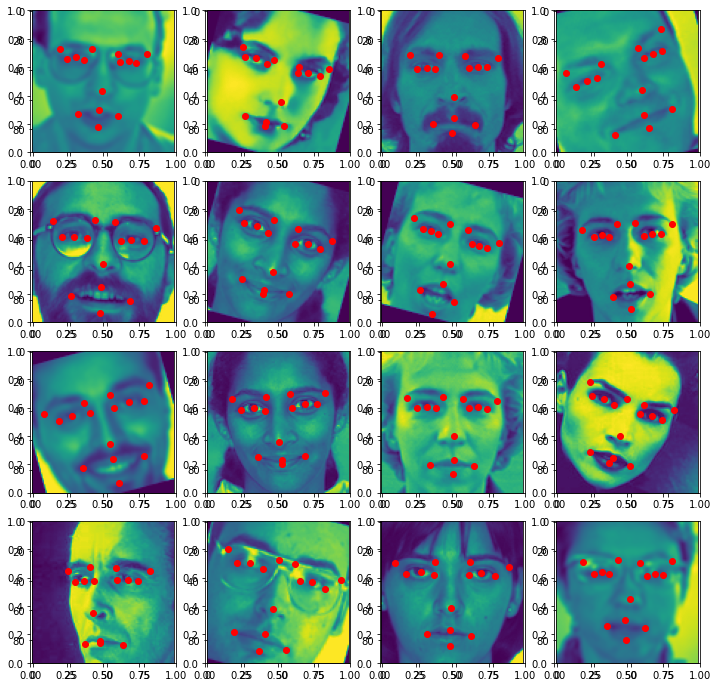

In [3]:
batch_size = 16

train_dataset = data_cstm.FacialKeypointDataset([(X_train),y_train])
val_dataset = data_cstm.FacialKeypointDataset([X_val,y_val])

vizloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(vizloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

utils_cstm.vis_im_keypoint(list(train_features), list(train_labels))


## Train Baseline Model

In [4]:
import baseline_model
baseline_net = baseline_model.BaselineNet()
print(baseline_net)

BaselineNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc6): Linear(in_features=2304, out_features=1024, bias=True)
  (drop6): Dropout(p=0.4, inplace=False)
  (fc7): Linear(in_features=1024, out_features=512, bias=True)
  (drop7):

In [5]:
batch_size = 128

trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(baseline_net.parameters(), lr=0.001 )
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-5)

history = train_cstm.train_model(baseline_net, trainloader, valloader, optimizer, scheduler,  criterion, epochs = 100)



Epoch 1               		 Training Loss: 17.9885725498347               		 Validation Loss: 9.165138555418162
Epoch 2               		 Training Loss: 10.12785495944239               		 Validation Loss: 8.93516745919045
Epoch 3               		 Training Loss: 9.950190618944697               		 Validation Loss: 9.76527291776658
Epoch 4               		 Training Loss: 9.907122258311416               		 Validation Loss: 9.477166594865912
Epoch 5               		 Training Loss: 9.809993322355147               		 Validation Loss: 9.333807471846555
Epoch 6               		 Training Loss: 9.749414612590297               		 Validation Loss: 8.911851057913026
Epoch 7               		 Training Loss: 9.752773382586527               		 Validation Loss: 9.561845940191692
Epoch 8               		 Training Loss: 9.652439548114835               		 Validation Loss: 8.937040699634618
Epoch 9               		 Training Loss: 9.613120885467406               		 Validation Loss: 8.899116352129882
Epoch 10     

In [6]:
with open(f'{BASE_DIR}/history/baseline/history.pickle', 'wb') as handle:
    pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
torch.save(baseline_net.state_dict(), f'{BASE_DIR}/history/baseline/baseline_weights.pth')

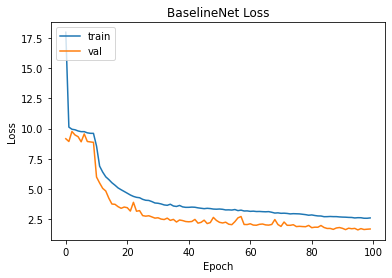

In [10]:
file = open(f'{BASE_DIR}/history/baseline/history.pickle','rb')
model_history = pickle.load(file)
file.close()

plt.plot(model_history['train_loss'])
plt.plot(model_history['val_loss'])
plt.title('BaselineNet Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

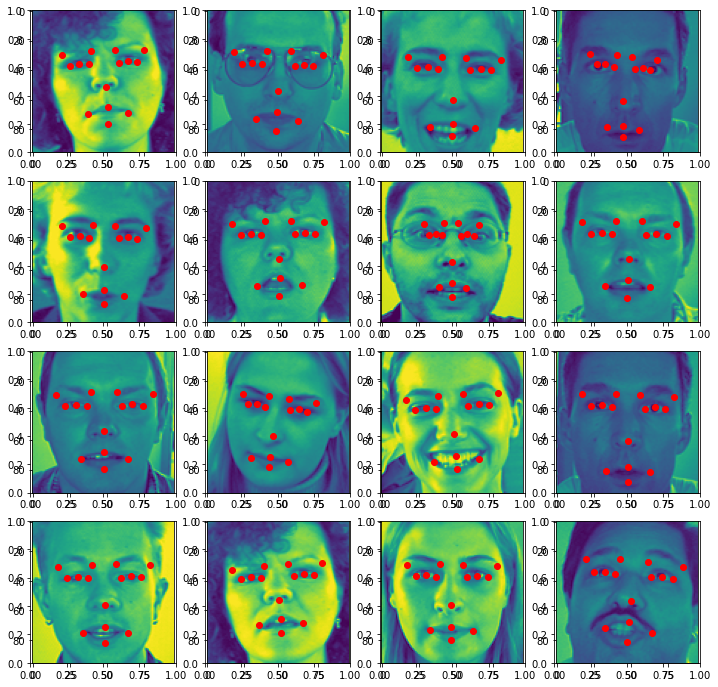

In [11]:

baseline_net_loaded = baseline_model.BaselineNet()
baseline_net_loaded.load_state_dict(torch.load(f'{BASE_DIR}/history/baseline/baseline_weights.pth'))

batch_size = 16

test_dataset = data_cstm.FacialKeypointDatasetTest(X_test)
testloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

imgs, pred_keypoints = train_cstm.def_net_test_samples(baseline_net_loaded, testloader)

utils_cstm.vis_im_keypoint(list(imgs.detach().numpy()),
                           list(pred_keypoints.detach().numpy()))